In [1]:
#!pip install opencv-python
#!pip install imblearn
#!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm import tqdm
from warnings import filterwarnings
import pickle
import os
import shutil
import random
import cv2

#Import sklearn modules
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay

#Import tf modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import plot_model

filterwarnings("ignore")
np.random.seed(0)

In [3]:
train_img = []
train_labels_not_encoded = []

test_img = []
test_labels_not_encoded = []

path_train = ('/kaggle/input/brain-tumor-classification-mri/Training/')
path_test = ('/kaggle/input/brain-tumor-classification-mri/Training/')

img_size= 160
for i in os.listdir(path_train):
    for j in tqdm(os.listdir(path_train+i)):
        train_img.append(cv2.resize(cv2.imread(path_train+i+'/'+j), (img_size,img_size))) 
        train_labels_not_encoded.append(i)
        
for i in os.listdir(path_test):
    for j in tqdm(os.listdir(path_test+i)):
        test_img.append(cv2.resize(cv2.imread(path_test+i+'/'+j), (img_size,img_size))) 
        test_labels_not_encoded.append(i)
        
train_img = np.array(train_img)#!! train_img = (np.array(train_img))
test_img = np.array(test_img)#!! test_img = (np.array(test_img))

100%|██████████| 826/826 [00:03<00:00, 266.10it/s]


In [4]:
y_train = pd.get_dummies(train_labels_not_encoded)
y_test = pd.get_dummies(test_labels_not_encoded)
labels=y_train.columns

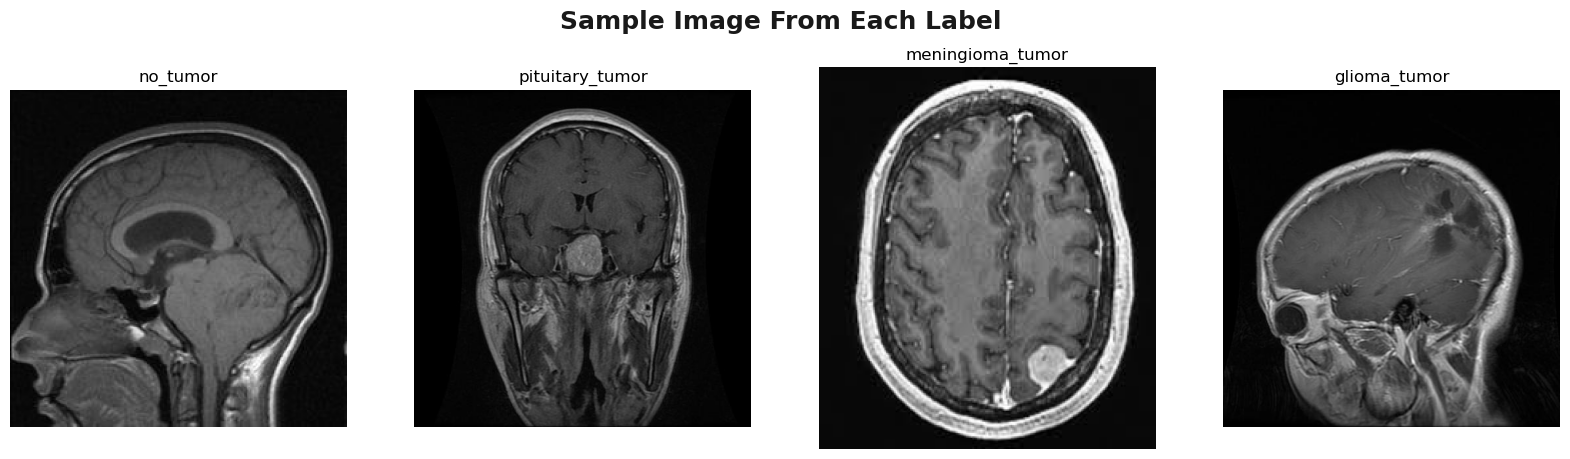

In [5]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
         color="black",y=0.61,x=0.4,alpha=0.9)
for count, ele in enumerate(os.listdir(path_train)):
    for j in os.listdir(path_train+ele):
        img= cv2.imread(path_train+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

In [6]:
print("Train size:", train_img.shape[0], "Test size:", test_img.shape[0])

Train size: 2870 Test size: 2870


One Hot encoded version:

In [7]:
y_train

,glioma_tumor,meningioma_tumor,no_tumor,pituitary_tumor
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
2865,1,0,0,0
2866,1,0,0,0
2867,1,0,0,0
2868,1,0,0,0


Since we have images which are gray, we should turn them gray scale.

In [8]:
train_img_gray = tf.image.rgb_to_grayscale(train_img)
test_img_gray = tf.image.rgb_to_grayscale(test_img)

# Model

Some functions to make things easier:

In [9]:
def clear_previous_calculations():
    try: 
        shutil.rmtree("logs")
    except Exception as e:
        pass
    
    for i in ["tumor_model.h5", "predictions.pkl"]:
        try: 
            os.remove(i)
        except Exception as e:
            pass

In [10]:
def get_model():
    data_augmentation = Sequential([layers.RandomFlip("horizontal_and_vertical",input_shape=(img_size, img_size, 1)),
                                    layers.RandomRotation(0.1),
                                    layers.RandomZoom(0.1)])

    model = Sequential([data_augmentation,
                        layers.Rescaling(1./255, input_shape=(img_size, img_size, 1)),
                        layers.Conv2D(32, 3, padding='same', activation='relu'),
                        layers.BatchNormalization(),
                        layers.Conv2D(32, 3, padding='same', activation='relu'),
                        layers.BatchNormalization(),
                        layers.Conv2D(64, 3, padding='same', activation='relu'),
                        layers.AveragePooling2D(),
                        layers.Conv2D(128, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.BatchNormalization(),
                        layers.Conv2D(246, 3, padding='same', activation='relu'),
                        layers.AveragePooling2D(),
                        layers.Conv2D(20, 3, padding='same', activation='relu'),
                        layers.BatchNormalization(),
                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(4, activation='softmax')
                       ])
    return model

In [11]:
def get_callbacks():
    tensorboard = TensorBoard(log_dir = 'logs', histogram_freq=1)
    checkpoint = ModelCheckpoint("tumor_model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.6, patience = 5, min_delta = 0.0000001,
                                  mode='auto',verbose=1, min_lr=0.0000000000001)
    return [tensorboard,checkpoint,reduce_lr]

In [12]:
def get_fig_and_axes_list(plot_count,column_number=2):
    """
    This function takes in the number of subplots to be plotted and the desired number of columns for the subplot grid. 
    It then calculates the number of rows required and generates a matplotlib figure with the given number of subplots 
    in a grid with the desired number of columns.
    
    Args:
    - plot_count: int, the number of subplots to be plotted
    - column_number: int, the number of columns in the subplot grid. Default value is 2.
    
    Returns:
    - fig: matplotlib Figure object, the generated figure
    - axes_list: list of matplotlib Axes objects, the axes of the subplots in the figure
    """
    reminder_num = plot_count % column_number
    row_num = (plot_count // column_number) + (reminder_num > 0)
    axes_list = []
    row_number_alignment = np.ones((row_num, column_number), dtype="int")
    if reminder_num != 0:
        row_number_alignment[-1,-(column_number - reminder_num):] = 0
    coefficient = (3.5 if plot_count==1 else 4.2)
    col_size = coefficient*column_number
    row_size = coefficient*row_num
    fig = plt.figure(figsize=(col_size, row_size), layout="constrained")
    spec = fig.add_gridspec(row_num, column_number)
    for i in range(row_number_alignment.shape[0]):
        for j in range(row_number_alignment.shape[1]):
            if row_number_alignment[i,j] == 1:
                ax = fig.add_subplot(spec[i,j])
                axes_list.append(ax)
    return fig,axes_list

In [13]:
def get_axes_list(length, column_number=2):
    fig, axes_list = get_fig_and_axes_list(length, column_number=column_number )
    return axes_list

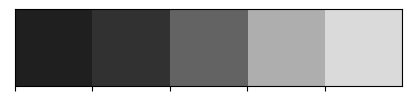

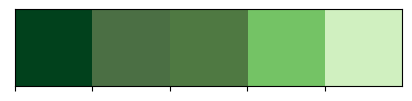

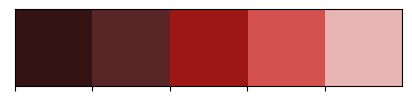

In [14]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [15]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #Supress warnings
clear_previous_calculations()
model = get_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 160, 160, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 160, 160, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 32)     128       
 hNormalization)                                      

In [16]:
epochs = 85
batch_size=32
all_callbacks = get_callbacks()
history = model.fit(train_img_gray, y_train, validation_split=0.2,  epochs=epochs, batch_size=batch_size,
                    callbacks=all_callbacks,  shuffle=True, verbose=1, workers=1)
model.load_weights('tumor_model.h5')

Epoch 1/85
72/72 [==============================] - ETA: 0s - loss: 1.1365 - accuracy: 0.6429
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to tumor_model.h5
72/72 [==============================] - 28s 210ms/step - loss: 1.1365 - accuracy: 0.6429 - val_loss: 6.9711 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/85
72/72 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.7404
Epoch 2: val_accuracy improved from 0.00000 to 0.00348, saving model to tumor_model.h5
72/72 [==============================] - 14s 190ms/step - loss: 0.6721 - accuracy: 0.7404 - val_loss: 1.3741 - val_accuracy: 0.0035 - lr: 0.0010
Epoch 3/85
72/72 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7861
Epoch 3: val_accuracy improved from 0.00348 to 0.50174, saving model to tumor_model.h5
72/72 [==============================] - 13s 180ms/step - loss: 0.5703 - accuracy: 0.7861 - val_loss: 1.0494 - val_accuracy: 0.5017 - lr: 0.0010
Epoch 4/85
72/72 [===

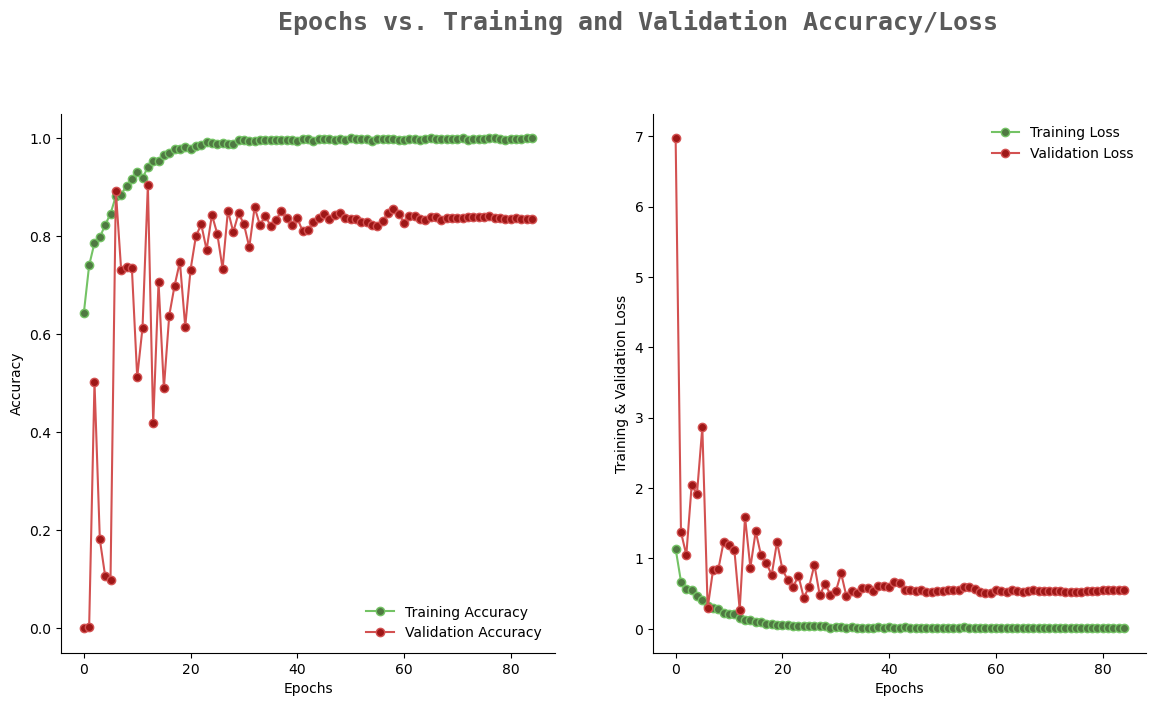

In [17]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_count = [i for i in range(len(train_acc))]

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)

sns.despine()
ax[0].plot(epochs_count, train_acc, marker='o',markerfacecolor=colors_green[2], color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs_count, val_acc, marker='o',markerfacecolor=colors_red[2], color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs_count, train_loss, marker='o', markerfacecolor=colors_green[2], color=colors_green[3],
           label='Training Loss')
ax[1].plot(epochs_count, val_loss, marker='o', markerfacecolor=colors_red[2], color=colors_red[3],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [18]:
pred_prob = model.predict(test_img_gray)
pred = np.argmax(pred_prob,axis=1)
y_test_new = np.argmax(y_test.to_numpy(),axis=1)

90/90 [==============================] - 2s 17ms/step


In [19]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       826
           1       0.92      0.90      0.91       822
           2       0.99      0.97      0.98       395
           3       0.97      0.99      0.98       827

    accuracy                           0.94      2870
   macro avg       0.95      0.95      0.95      2870
weighted avg       0.94      0.94      0.94      2870



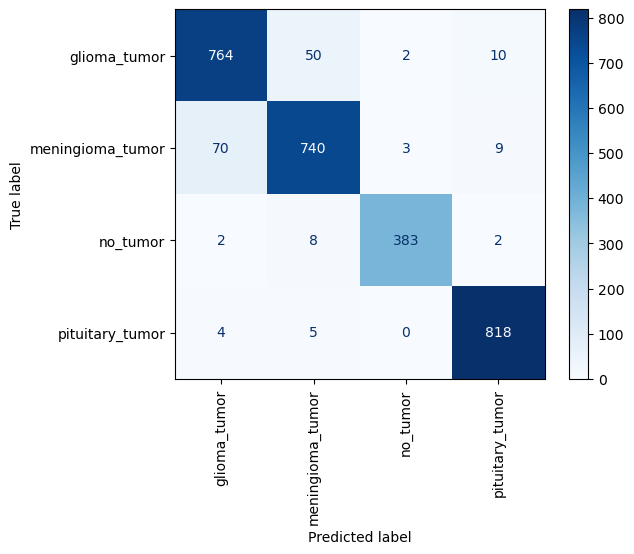

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test_new, pred, display_labels=labels, 
                                        cmap='Blues', xticks_rotation="vertical")

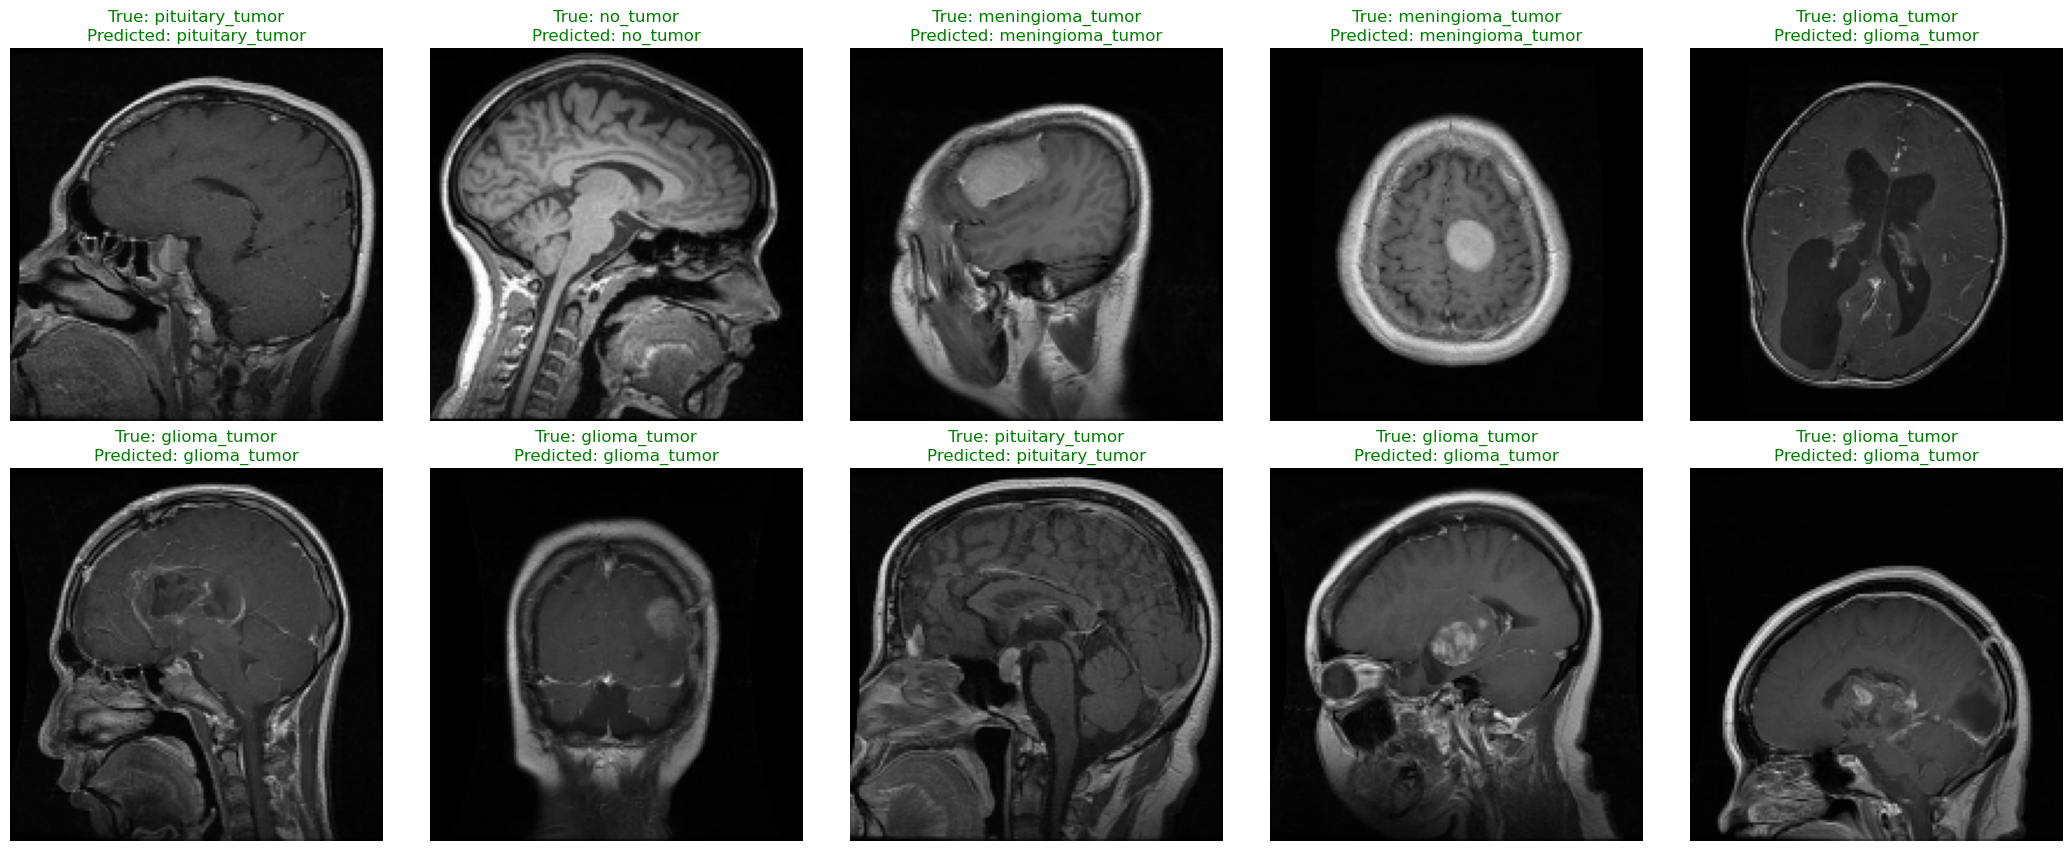

In [21]:
fig,ax_list = get_fig_and_axes_list(10,5)
random_image_index = np.random.randint(test_img.shape[0], size=10)
for count, ele in enumerate(random_image_index):
    ax_list[count]
    ax_list[count].imshow(test_img[ele])
    color = ("green" if pred[ele] == y_test_new[ele] else "red")
    ax_list[count].set_title(f"True: {test_labels_not_encoded[ele]}\nPredicted: { labels[pred[ele]] }", color=color)
    ax_list[count].axis('off')

In [22]:
model.save('saved_model')
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)
with open('predictions.pkl', 'wb') as file_pred:
    pickle.dump(pred, file_pred)    

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......average_pooling2d
.........vars
......average_pooling2d_1
.........vars
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.........vars
............0
............1
......conv2d_4
.........vars
............0
............1
......conv2d_5
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......

### I will be waiting for your feedback :)